# [ 머신러닝 2주차 과제  ]
## (Imbalanced sampling, feature selection)
### 문제 1. 
SMOTE와 ADASYN에서 k-neigbors를 조절하여 변화에 대해 논의할 것
> 임의로 분류문제화 > oversampling 기법 적용


In [18]:
from collections import Counter
from sklearn.datasets import make_classification

# 레이블 3개, 10개의 피쳐, 클래스당 클러스터 수 1개, 2000개 샘플
# X, y = make_classification(n_classes=3, weights=[0.03, 0.07,0.9],n_features=10, 
#                            n_clusters_per_class=1, n_samples=2000, random_state=10)

def create_dataset(n_samples=2000, weights=(0.01, 0.01, 0.8), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

X, y = create_dataset(n_samples=2000, weights=(0.05, 0.2, 0.75))

print('Original dataset shape %s' % Counter(y)) 

Original dataset shape Counter({2: 1486, 1: 406, 0: 108})


매우 imbalanced 하게 생성된 모습

In [19]:
df = pd.DataFrame(X, columns=list(range(2)))
df['target'] = y

In [20]:
df

,0,1,target
0,0.451206,0.885176,1
1,0.343304,-1.379539,0
2,-0.877345,0.577235,2
3,0.107621,0.733509,1
4,-0.628419,0.781609,1
...,...,...,...
1995,0.897309,0.845188,1
1996,1.245978,0.706662,1
1997,-0.751757,1.198834,2
1998,-0.249217,0.982045,2


In [21]:
df['target'].value_counts()

2    1486
1     406
0     108
Name: target, dtype: int64

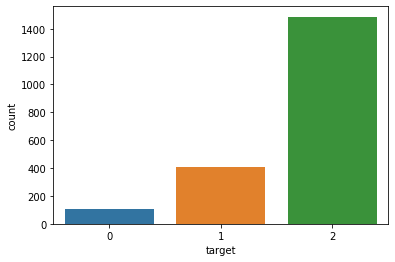

In [22]:
import seaborn as sns
sns.countplot(data=df, x='target')

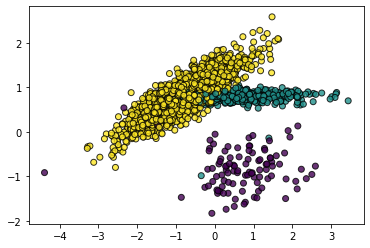

In [23]:
# 원래 데이터의 분포
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k')

### 1) SMOTE

In [24]:
# ex)
from imblearn.over_sampling import SMOTE, ADASYN
X_rr, y_rr = SMOTE(sampling_strategy='auto', random_state=2020, k_neighbors=10).fit_resample(X, y)

Using TensorFlow backend.


In [25]:
df_re = pd.DataFrame(X_rr, columns=list(range(2)))

In [26]:
df_re # 개수 증가된 모습

,0,1
0,0.451206,0.885176
1,0.343304,-1.379539
2,-0.877345,0.577235
3,0.107621,0.733509
4,-0.628419,0.781609
...,...,...
4453,0.734089,0.631816
4454,0.736562,0.687182
4455,1.249007,0.884057
4456,1.943071,0.882061


In [27]:
df_re['target'] = y_rr
df_re['target'].value_counts() # 다수 클래스의 개수만큼 맞춰줌. 

2    1486
1    1486
0    1486
Name: target, dtype: int64

In [28]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import make_pipeline # imblearn에서 pipline불러오는 것 주의
from sklearn.svm import LinearSVC
from collections import Counter

from sklearn.metrics import classification_report, accuracy_score # 성능 측정

(4458, 2) (4458,)
0.860699865410498
(4458, 2) (4458,)
0.8822341857335128
(4458, 2) (4458,)
0.8981606101390758


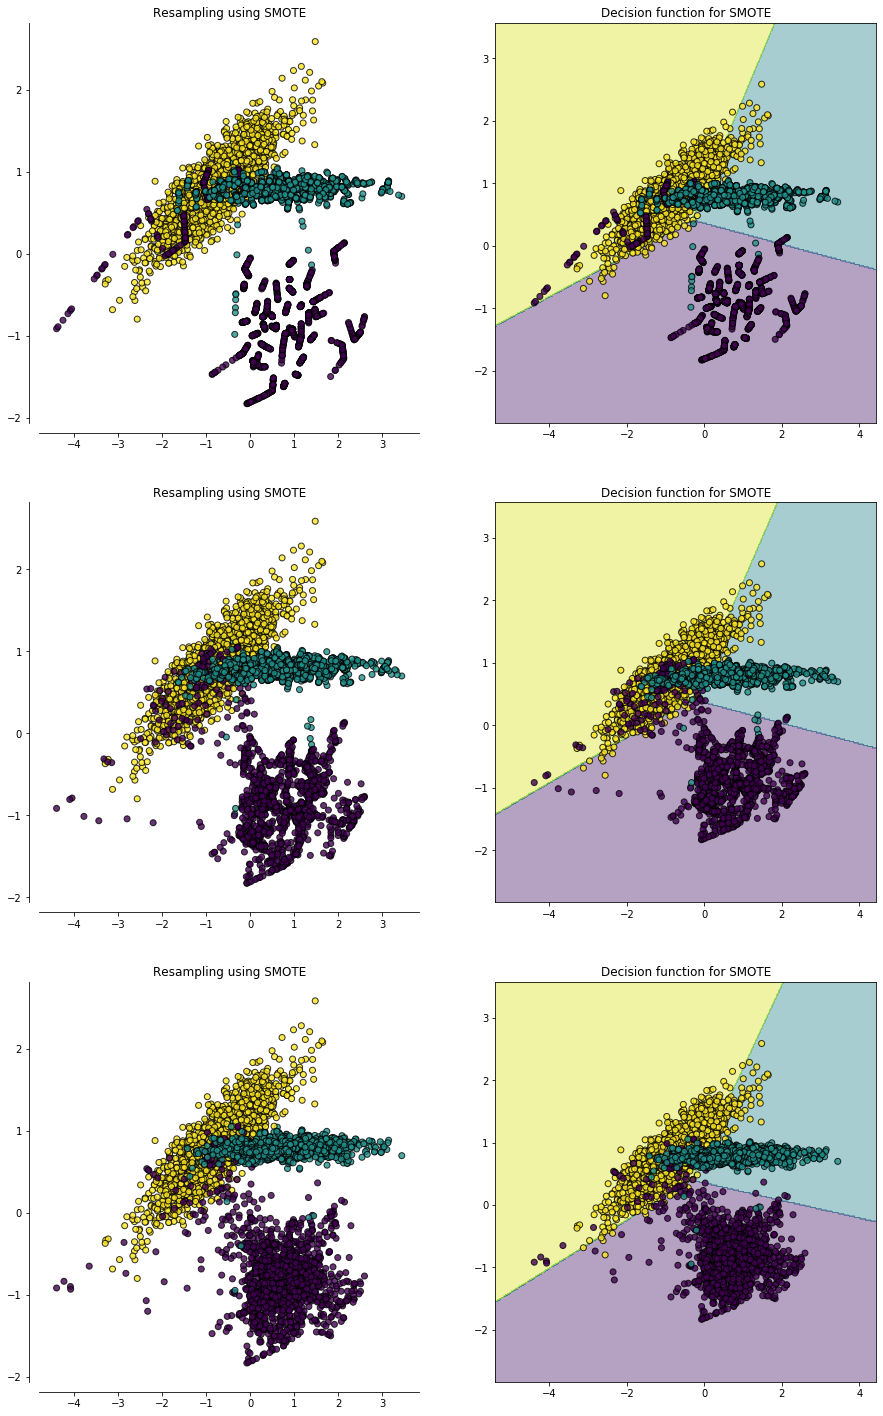

In [29]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    

# plot 그리기
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 25))

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))

for ax, sampler in zip(ax_arr, (
                SMOTE(sampling_strategy='auto', random_state=2020, k_neighbors=1),
                SMOTE(sampling_strategy='auto', random_state=2020, k_neighbors=10),
                SMOTE(sampling_strategy='auto', random_state=2020, k_neighbors=100))):

    plot_resampling(X, y, sampler, ax[0])
    ax[0].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
    
    X_res, y_res = sampler.fit_resample(X, y)
    print(X_res.shape, y_res.shape)
    clf = LinearSVC(random_state=2020) 
    clf.fit(X_res, y_res)
    
    # 성능 측정 
    train_pred = clf.predict(X_res) # train predict
#     print(classification_report(y_res, train_pred, target_names = target_names))
    print(accuracy_score(y_res, train_pred))
    
    plot_decision_function(X_res, y_res, clf, ax[1])
    ax[1].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))

In [30]:
# 최적의 k찾기 (gride search)


### 2) ADASYN

(4470, 2) (4470,)
0.5568232662192394
(4454, 2) (4454,)
0.5972159856308936
(4438, 2) (4438,)
0.7823343848580442


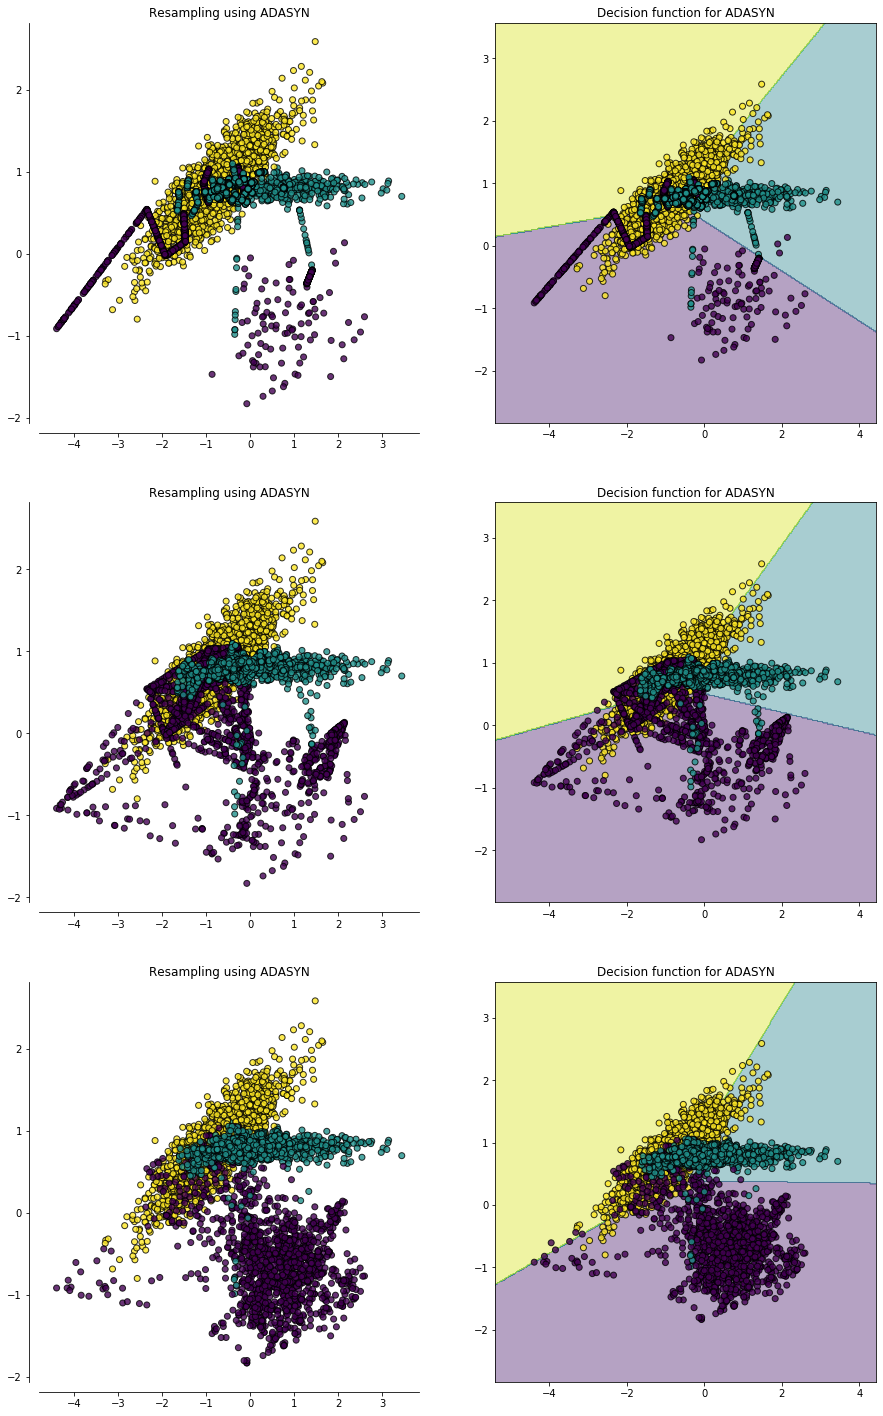

In [31]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 25))

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))

for ax, sampler in zip(ax_arr, (
                ADASYN(sampling_strategy='auto', random_state=2020, n_neighbors=1),
                ADASYN(sampling_strategy='auto', random_state=2020, n_neighbors=10),
                ADASYN(sampling_strategy='auto', random_state=2020, n_neighbors=100))):\
    
    plot_resampling(X, y, sampler, ax[0])
    ax[0].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
    
    X_res, y_res = sampler.fit_resample(X, y)
    print(X_res.shape, y_res.shape)
    clf = LinearSVC(random_state=2020) 
    clf.fit(X_res, y_res)
    
    # 성능 측정 
    train_pred = clf.predict(X_res) # train predict
    print(accuracy_score(y_res, train_pred))
    
    plot_decision_function(X_res, y_res, clf, ax[1])
    ax[1].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    

### 문제 2. 
특성변수의 선택에서 교재에 있는 digit 데이터를 이용하여 목적변수가 분류일 때 chi2, f_classif, 그리고 mutual_info_classif를 적용한 결과를 비교하라.
- chi-squre
- F
- mutual_classification

In [32]:
# MNIST 데이터
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
X,y=load_digits(return_X_y=True)

In [33]:
print(X.shape, y.shape)

(1797, 64) (1797,)


In [34]:
df = pd.DataFrame(X, columns=list(range(64)))
df['target'] = y

In [35]:
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


In [36]:
df['target'].value_counts() # 매우 균등한 모습~!

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64

## 1) 카이제곱

In [37]:
sb = SelectKBest(score_func=chi2, k=20)
X_chi=sb.fit_transform(X,y)
X_chi.shape

(1797, 20)

In [38]:
X_chi

array([[ 1.,  0., 15., ...,  6.,  0.,  0.],
       [ 5.,  0.,  9., ...,  0., 10.,  0.],
       [12.,  0., 14., ...,  0., 16.,  9.],
       ...,
       [ 1.,  0.,  2., ...,  2.,  6.,  0.],
       [ 0.,  0., 15., ...,  5., 12.,  0.],
       [ 1.,  0.,  1., ...,  8., 12.,  1.]])

In [39]:
X_chi.shape

(1797, 20)

In [40]:
chi_select = pd.DataFrame(sb.get_support()).rename(columns={0:'bool'})

In [41]:
chi_select_index = chi_select.query('bool==True').index
chi_select_index

Int64Index([5, 6, 13, 19, 20, 21, 26, 28, 30, 33, 34, 41, 42, 43, 44, 46, 54,
            58, 61, 62],
           dtype='int64')

In [42]:
sb.scores_

array([          nan,  811.90700411, 3501.28249552,  698.9252572 ,
        438.52969882, 3879.81925999, 3969.45823205, 1193.5608181 ,
         24.79521396, 2953.83108764, 2583.65198939,  388.24205944,
        824.69094853, 3676.48924765, 1983.5796061 ,  597.24198237,
          8.95886124, 1924.21690377, 2409.27140681, 3556.31594594,
       4871.94194551, 4782.19921618, 2155.17378998,  376.76583333,
          7.90090158, 2471.82418401, 4515.48149826, 2986.64314847,
       3724.09567634, 3208.64686641, 5138.07412439,   35.71270718,
                 nan, 5688.25079535, 5262.46646904, 3165.0605867 ,
       3231.63943369, 2532.99695611, 3288.81403655,           nan,
        142.85082873, 3863.85787901, 6416.0867248 , 5448.25154235,
       4079.73153383, 2134.02540236, 4486.34097862,  313.53898127,
         70.39927392,  449.72327313, 2801.97224468, 1527.54519627,
       1653.15892311, 3073.99803898, 5251.21748723,  683.88227339,
          9.15254237,  851.06791492, 3800.2473108 ,  730.92975

In [43]:
# 모델 피팅
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# split
tr_x, te_x, tr_y, te_y = train_test_split(X_chi, y, test_size=0.2, random_state=2020) 

clf = DecisionTreeClassifier(max_depth=10, random_state=2020)
clf.fit(tr_x, tr_y)
pred = clf.predict(te_x)
print('Chi-square accuracy : ' + str(accuracy_score(te_y, pred)))

Chi-square accuracy : 0.8694444444444445


## 2) F 통계량

In [44]:
sb_f=SelectKBest(score_func=f_classif,k=20)
X_f=sb_f.fit_transform(X,y)
X_f.shape

C:\Users\이다은\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 0 32 39] are constant.
  UserWarning)
C:\Users\이다은\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(1797, 20)

In [45]:
f_select = pd.DataFrame(sb_f.get_support()).rename(columns={0:'bool'})

In [46]:
f_select_index = f_select.query('bool==True').index
f_select_index

Int64Index([2, 10, 13, 20, 21, 26, 28, 30, 33, 34, 36, 38, 42, 43, 44, 46, 54,
            58, 60, 61],
           dtype='int64')

In [47]:
sb_f.scores_

array([         nan,  39.77670877, 161.66962131,  68.01284271,
        37.085693  , 126.41541048,  74.26391138,  17.28204084,
         1.73328376,  93.87300085, 205.13348801,  38.86089592,
        51.62522088, 166.97247543,  37.41350206,  10.97417161,
         0.71100904,  55.32842977, 138.10227535, 138.68433936,
       202.43528942, 234.21960737,  50.24960622,  11.47100745,
         0.87782927, 103.80241354, 293.09983163, 146.07649117,
       236.7444881 , 127.5841692 , 189.18278073,   4.03517196,
                nan, 312.78489658, 254.37524393, 136.20370677,
       220.78357776, 110.63540569, 147.22496837,          nan,
         6.90281305, 123.36344683, 268.76998164, 222.53295915,
       159.07418303,  85.78384611, 169.33840921,  10.53627776,
         1.35922709,  12.19342228, 115.41402772,  83.87060144,
        88.50634019, 139.19382977, 162.49090456,  17.53002847,
         1.01703597,  35.49323239, 163.49692878,  68.70759521,
       200.35796882, 178.71033228, 106.03150882,  30.67

In [48]:
# 모델 피팅
tr_x, te_x, tr_y, te_y = train_test_split(X_f, y, test_size=0.2, random_state=2020) 

clf = DecisionTreeClassifier(max_depth=10, random_state=2020)
clf.fit(tr_x, tr_y)
pred = clf.predict(te_x)
print('F accuracy : ' + str(accuracy_score(te_y, pred)))

F accuracy : 0.8722222222222222


## 3) Mutual classification

In [50]:
sb_m = SelectKBest(score_func=mutual_info_classif,k=20)
X_m = sb_m.fit_transform(X,y)
X_m.shape

(1797, 20)

In [51]:
m_select = pd.DataFrame(sb_m.get_support()).rename(columns={0:'bool'})
m_select_index = m_select.query('bool==True').index
m_select_index

# f 선택과 거의 비슷함. 

Int64Index([2, 10, 13, 20, 21, 26, 28, 30, 33, 34, 35, 36, 38, 42, 43, 46, 53,
            54, 58, 61],
           dtype='int64')

In [52]:
sb_m.scores_

array([0.        , 0.12112913, 0.3325159 , 0.19307702, 0.14641047,
       0.26168433, 0.19029475, 0.04355392, 0.        , 0.24016518,
       0.32823817, 0.11185346, 0.21554986, 0.33628235, 0.12345249,
       0.04504966, 0.00217049, 0.19323477, 0.23694761, 0.28741183,
       0.38235636, 0.42566913, 0.23759009, 0.03412868, 0.        ,
       0.28180326, 0.40898816, 0.30542029, 0.38660238, 0.31060507,
       0.42778511, 0.04068891, 0.00316842, 0.43778972, 0.41868984,
       0.31965639, 0.36055177, 0.2667896 , 0.39812845, 0.        ,
       0.01927771, 0.27446057, 0.40948271, 0.40909314, 0.28031591,
       0.18481835, 0.32666972, 0.01340621, 0.00329553, 0.06991102,
       0.25065608, 0.26195073, 0.23082167, 0.32317736, 0.32657179,
       0.05852817, 0.        , 0.08065764, 0.36600445, 0.24825574,
       0.27913465, 0.3482723 , 0.27660135, 0.08998007])

In [53]:
# 모델 피팅
tr_x, te_x, tr_y, te_y = train_test_split(X_m, y, test_size=0.2, random_state=2020) 

clf = DecisionTreeClassifier(max_depth=10, random_state=2020)
clf.fit(tr_x, tr_y)
pred = clf.predict(te_x)
print('Mutual accuracy : ' + str(accuracy_score(te_y, pred)))

Mutual accuracy : 0.8444444444444444


## 4) Model's Feature importance

In [58]:
tr_x, te_x, tr_y, te_y = train_test_split(X, y, test_size=0.2, random_state=2020) 
clf = DecisionTreeClassifier(random_state=4)
clf.fit(tr_x, tr_y)
pred = clf.predict(te_x)
print('Single accuracy : ' + str(accuracy_score(te_y, pred)))

Single accuracy : 0.8666666666666667


In [60]:
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0.         0.00069589 0.01737468 0.         0.00657847 0.03915055
 0.         0.         0.         0.00368051 0.01607259 0.00104384
 0.00601753 0.01984821 0.00284157 0.         0.         0.00069589
 0.0103002  0.014517   0.03881372 0.07914363 0.001299   0.
 0.         0.00069589 0.06330254 0.05407909 0.04670722 0.0126148
 0.00204804 0.         0.         0.05002812 0.00880646 0.01323439
 0.06844939 0.01445117 0.01393904 0.         0.         0.
 0.06717712 0.04924069 0.0061552  0.00181776 0.01512367 0.
 0.         0.00125261 0.01459314 0.01029021 0.00219138 0.01231993
 0.022918   0.00138148 0.         0.         0.00162375 0.00409252
 0.05670223 0.02019537 0.         0.00646154]


In [61]:
feat_importance

array([0.        , 0.00069589, 0.01737468, 0.        , 0.00657847,
       0.03915055, 0.        , 0.        , 0.        , 0.00368051,
       0.01607259, 0.00104384, 0.00601753, 0.01984821, 0.00284157,
       0.        , 0.        , 0.00069589, 0.0103002 , 0.014517  ,
       0.03881372, 0.07914363, 0.001299  , 0.        , 0.        ,
       0.00069589, 0.06330254, 0.05407909, 0.04670722, 0.0126148 ,
       0.00204804, 0.        , 0.        , 0.05002812, 0.00880646,
       0.01323439, 0.06844939, 0.01445117, 0.01393904, 0.        ,
       0.        , 0.        , 0.06717712, 0.04924069, 0.0061552 ,
       0.00181776, 0.01512367, 0.        , 0.        , 0.00125261,
       0.01459314, 0.01029021, 0.00219138, 0.01231993, 0.022918  ,
       0.00138148, 0.        , 0.        , 0.00162375, 0.00409252,
       0.05670223, 0.02019537, 0.        , 0.00646154])

### 4가지 select 방법 비교

In [62]:
cc = sb.scores_
ff = sb_f.scores_
mm = sb_m.scores_

In [69]:
a = pd.DataFrame(cc).rename(columns={0:'chi'})
b = pd.DataFrame(ff).rename(columns={0:'f'})
c = pd.DataFrame(mm).rename(columns={0:'mutual'})
d = pd.DataFrame(feat_importance).rename(columns={0:'fe'})

In [71]:
all = pd.concat([a,b,c,d], axis=1)

In [76]:
all.reset_index(inplace=True)

In [77]:
all.head(10)  # 변수 선택 방법에 따라 선택되는 변수가 차이가 있다. 

,index,chi,f,mutual,fe
0,0,NaN,NaN,0.000000,0.000000
1,1,811.907004,39.776709,0.121129,0.000696
2,2,3501.282496,161.669621,0.332516,0.017375
3,3,698.925257,68.012843,0.193077,0.000000
4,4,438.529699,37.085693,0.146410,0.006578
5,5,3879.819260,126.415410,0.261684,0.039151
6,6,3969.458232,74.263911,0.190295,0.000000
7,7,1193.560818,17.282041,0.043554,0.000000
8,8,24.795214,1.733284,0.000000,0.000000
9,9,2953.831088,93.873001,0.240165,0.003681


index      19.000000
chi      3556.315946
Name: 19, dtype: float64


Text(0.5, 1.0, 'chi-square score')

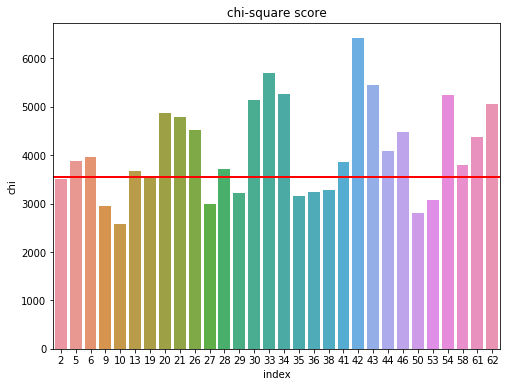

In [116]:
# chisquare
plt.figure(figsize=(8,6))
aaa = pd.DataFrame(all['chi'].sort_values(ascending=False))
aaa = aaa.reset_index()
aaa = aaa.iloc[:30, :]
print(aaa.iloc[19,:])
sns.barplot(x=aaa['index'], y=aaa['chi'])
plt.axhline(y=3556.315946, color='r', linewidth=2)
plt.title('chi-square score')

index     38.000000
f        147.224968
Name: 19, dtype: float64


Text(0.5, 1.0, 'F score')

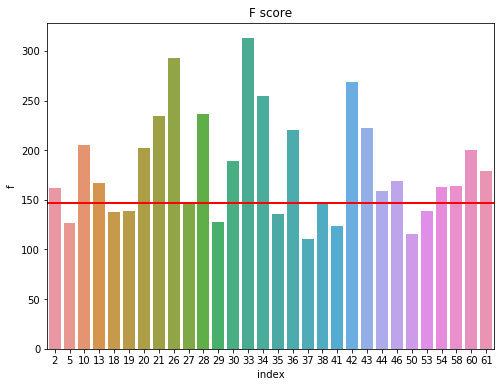

In [117]:
# f
plt.figure(figsize=(8,6))
aaa = pd.DataFrame(all['f'].sort_values(ascending=False))
aaa = aaa.reset_index()
aaa = aaa.iloc[:30, :]
print(aaa.iloc[19,:])
sns.barplot(x=aaa['index'], y=aaa['f'])
plt.axhline(y=147.224968, color='r', linewidth=2)
plt.title('F score')

index     35.000000
mutual     0.319656
Name: 19, dtype: float64


Text(0.5, 1.0, 'Mutual score')

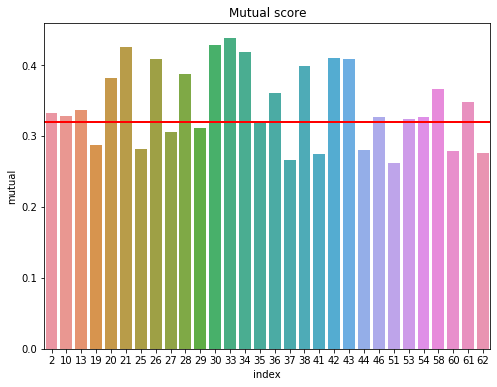

In [118]:
# mutual
plt.figure(figsize=(8,6))
aaa = pd.DataFrame(all['mutual'].sort_values(ascending=False))
aaa = aaa.reset_index()
aaa = aaa.iloc[:30, :]
print(aaa.iloc[19,:])
sns.barplot(x=aaa['index'], y=aaa['mutual'])
plt.axhline(y=0.319656, color='r', linewidth=2)
plt.title('Mutual score')

index    37.000000
fe        0.014451
Name: 19, dtype: float64


Text(0.5, 1.0, 'Feature importance score')

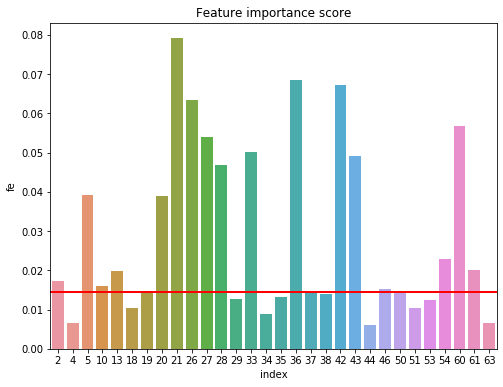

In [119]:
# Fe
plt.figure(figsize=(8,6))
aaa = pd.DataFrame(all['fe'].sort_values(ascending=False))
aaa = aaa.reset_index()
aaa = aaa.iloc[:30, :]
print(aaa.iloc[19,:])
sns.barplot(x=aaa['index'], y=aaa['fe'])
plt.axhline(y=0.014451, color='r', linewidth=2)
plt.title('Feature importance score')